# Preparación de los datos

In [2]:
import os
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
import folium
import warnings
from sklearn.impute import KNNImputer

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *

warnings.filterwarnings('ignore')


In [500]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Anio2017.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [501]:
# Se obtienen los datos de 2017
df_acoustics = pd.read_csv('data/raw/Anio2017.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


370

In [502]:
# Se les concatenan los datos del resto de años de los csv
for year in range(2018, 2024):
    path = 'data/raw/Anio' + str(year) + '.csv'
    df = pd.read_csv(path, encoding=result['encoding'], delimiter=';')
    df_acoustics = pd.concat([df_acoustics, df])

len(df_acoustics)


2292

In [503]:
# Se le concatenan, ahora, los datos del resto de años de los xls
# Se parte de 2012 porque en 2011 faltan 5 zonas
month_dict = {'ene': '01',
                'feb': '02',
                'mar': '03',
                'abr': '04',
                'may': '05',
                'jun': '06',
                'jul': '07',
                'ago': '08',
                'sep': '09',
                'oct': '10',
                'nov': '11',
                'dic': '12'
                }

skiprows = 3

for year in range(2012, 2017):
    path = 'data/raw/anio' + str(year) + '.xls'
    if year == 2015:
        month_dict_2015 = month_dict.copy()
        month_dict_2015.pop('jun')
        month_dict_2015.pop('jul')
        for sheet in range(10):
            df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
            df_xls['Fecha'] = list(month_dict_2015.keys())[sheet] + '-' + str(year)[2:]
            df_acoustics = pd.concat([df_acoustics, df_xls])
    else:
        if year == 2014:
            skiprows += 1
        for sheet in range(12):
            df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
            df_xls['Fecha'] = list(month_dict.keys())[sheet] + '-' + str(year)[2:]
            df_acoustics = pd.concat([df_acoustics, df_xls])

df_acoustics = df_acoustics.reset_index(drop=True)

len(df_acoustics)


4193

In [504]:
# Se elimina la columna "Unnamed"
df_acoustics = df_acoustics.drop(columns='Unnamed: 3')

df_acoustics.head()


,Fecha,NMT,Situación,Ld,Le,Ln,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99,Nombre,LAeq,L1,L10,L50,L90,L99
0,ene-17,1,Paseo de Recoletos,"69,1","69,2","66,5","68,2",74,"71,3","65,8","57,9",50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ene-17,2,Carlos V,"70,2","69,8","66,9","69,3","75,5","71,4","67,9","61,2","54,8",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ene-17,3,Plaza del Carmen,"67,7","60,9","62,8","65,8","75,4",66,"58,5","53,4","50,7",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ene-17,4,Plaza de España,"65,9","65,9","62,4",65,"72,7","67,4","63,5","56,4","49,1",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ene-17,5,Barrio del Pilar,"65,7","66,2","60,1","64,6","74,4",67,"59,7","46,9","37,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [505]:
# Se fusionan las columnas "Nombre" y "Situación", que son la misma cosa
df_acoustics['Situación'] = df_acoustics['Situación'].fillna(df_acoustics['Nombre'])
df_acoustics = df_acoustics.drop(columns='Nombre')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   Ld         2912 non-null   object
 4   Le         2912 non-null   object
 5   Ln         2912 non-null   object
 6   LAeq24     3344 non-null   object
 7   LAS01      3342 non-null   object
 8   LAS10      3342 non-null   object
 9   LAS50      3342 non-null   object
 10  LAS90      3342 non-null   object
 11  LAS99      3342 non-null   object
 12  LAeq       728 non-null    object
 13  L1         728 non-null    object
 14  L10        728 non-null    object
 15  L50        728 non-null    object
 16  L90        728 non-null    object
 17  L99        728 non-null    object
dtypes: object(18)
memory usage: 589.8+ KB


In [506]:
# Se fusionan las demás columnas con datos comunes
for tuple in [('LAeq24', 'LAeq'), ('LAS01', 'L1'), ('LAS10', 'L10'), ('LAS50', 'L50'), ('LAS90', 'L90'), ('LAS99', 'L99')]:
    df_acoustics[tuple[0]] = df_acoustics[tuple[0]].fillna(df_acoustics[tuple[1]])

df_acoustics = df_acoustics.drop(columns=['LAeq', 'L1', 'L10', 'L50', 'L90', 'L99'])

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   Ld         2912 non-null   object
 4   Le         2912 non-null   object
 5   Ln         2912 non-null   object
 6   LAeq24     4072 non-null   object
 7   LAS01      4070 non-null   object
 8   LAS10      4070 non-null   object
 9   LAS50      4070 non-null   object
 10  LAS90      4070 non-null   object
 11  LAS99      4070 non-null   object
dtypes: object(12)
memory usage: 393.2+ KB


In [507]:
# Se borran las columnas con datos de mañana, día y noche, pues no existen para todos los años
df_acoustics = df_acoustics.drop(columns=['Ld', 'Le', 'Ln'])

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4070 non-null   object
 5   LAS10      4070 non-null   object
 6   LAS50      4070 non-null   object
 7   LAS90      4070 non-null   object
 8   LAS99      4070 non-null   object
dtypes: object(9)
memory usage: 294.9+ KB


In [508]:
# Se buscan los valores donde las "LAS" son nulos pero "LAeq" no
df_acoustics[df_acoustics['LAS50'].isna() & df_acoustics['Situación'].notna()]


,Fecha,NMT,Situación,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99
4143,nov-16,16,Arturo Soria,61.5,NaN,NaN,NaN,NaN,NaN
4147,nov-16,20,Avda de Moratalaz,62.1,NaN,NaN,NaN,NaN,NaN


In [509]:
# Se busca el mes anterior a ese punto
df_acoustics[((df_acoustics['Situación'] == 'Arturo Soria') | (df_acoustics['Situación'] == 'Avda de Moratalaz'))
                & (df_acoustics['Fecha'] == 'oct-16')
              ]


,Fecha,NMT,Situación,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99
4112,oct-16,16,Arturo Soria,60.8,67.8,64.5,58.6,42.7,37.1
4116,oct-16,20,Avda de Moratalaz,61.6,70.8,64.2,58.0,44.8,36.1


In [510]:
# Se imputan esos nulos al mes anterior
for col, values in [('LAS01', [67.8, 70.8]), ('LAS10', [64.5, 64.2]), ('LAS50', [58.6, 58.0]), ('LAS90', [42.7, 44.8]), ('LAS99', [37.1, 36.1])]:
    fill_dict =  {4143: values[0], 4147: values[1]}
    df_acoustics[col] = df_acoustics[col].fillna(value=fill_dict)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4072 non-null   object
 5   LAS10      4072 non-null   object
 6   LAS50      4072 non-null   object
 7   LAS90      4072 non-null   object
 8   LAS99      4072 non-null   object
dtypes: object(9)
memory usage: 294.9+ KB


In [511]:
# Se borran los demás nulos, pues son errores de la conversion de los xls
# Todavía existen nulos, pero no son fallos de conversión y están en formato "string"
df_acoustics = df_acoustics.dropna()

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4072 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4072 non-null   object
 1   NMT        4072 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4072 non-null   object
 5   LAS10      4072 non-null   object
 6   LAS50      4072 non-null   object
 7   LAS90      4072 non-null   object
 8   LAS99      4072 non-null   object
dtypes: object(9)
memory usage: 318.1+ KB


In [512]:
# Se añaden los meses faltantes del año 15 con nulos. Se imputarán más adelante
for month in ['jun-15', 'jul-15']:
    df_summer_15 = df_acoustics[df_acoustics['Fecha'] == 'ago-15'].copy()
    df_summer_15[['LAeq24', 'LAS01', 'LAS10', 'LAS50', 'LAS90', 'LAS99', 'NMT']] = np.nan
    df_summer_15['Fecha'] = month
    df_acoustics = pd.concat([df_acoustics, df_summer_15])


In [513]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['Fecha'] = df_acoustics['Fecha'].str.split('-').apply(lambda x: f'{month_dict[x[0]]}-{x[1]}')
df_acoustics['Fecha'] = pd.to_datetime(df_acoustics['Fecha'], format='%m-%y')

df_acoustics = df_acoustics.rename(columns={'Fecha': 'mes'})

df_acoustics = df_acoustics.set_index('mes')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01',
               ...
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01'],
              dtype='datetime64[ns]', name='mes', length=4134, freq=None)

In [514]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics = df_acoustics.astype(str)

for col in df_acoustics.columns[2:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = df_acoustics[col].apply(lambda x: float(x) if x != 'N/D' else np.nan)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4134 entries, 2012-01-01 to 2023-02-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NMT        4134 non-null   object 
 1   Situación  4134 non-null   object 
 2   LAeq24     4019 non-null   float64
 3   LAS01      4005 non-null   float64
 4   LAS10      4005 non-null   float64
 5   LAS50      4005 non-null   float64
 6   LAS90      4005 non-null   float64
 7   LAS99      4005 non-null   float64
dtypes: float64(6), object(2)
memory usage: 290.7+ KB


In [515]:
# Se cambian los nombres de las columnas para mayor claridad
df_acoustics = df_acoustics.rename(columns={'NMT': 'num_medidas',
                                          'Situación': 'zonas',
                                            'LAeq24': 'sonido_24_h',
                                            'LAS01': 'sonido_superado_1%',
                                            'LAS10': 'sonido_superado_10%',
                                            'LAS50': 'sonido_superado_50%',
                                            'LAS90': 'sonido_superado_90%',
                                            'LAS99': 'sonido_superado_99%'
                                            }
                                    )                   

df_acoustics.head()


,num_medidas,zonas,sonido_24_h,sonido_superado_1%,sonido_superado_10%,sonido_superado_50%,sonido_superado_90%,sonido_superado_99%
mes,,,,,,,,
2012-01-01,1,Paseo de Recoletos,68.7,74.9,72.0,66.5,59.1,51.0
2012-01-01,86,Tres Olivos,58.1,66.9,61.2,52.0,39.3,36.6
2012-01-01,55,Urbanización Embajada II,55.9,63.5,58.1,51.1,44.3,41.3
2012-01-01,50,Pza de Castilla,66.8,72.8,68.4,64.9,58.3,50.8
2012-01-01,48,Castellana,63.9,69.3,66.5,62.5,54.8,46.1


In [516]:
# Se pivota la tabla para que cada columna sea una zona y los valores sean el valor que supera los que hay el 50% del tiempo 
# Así podemos decir que la mayoría del tiempo se supera tal o cual valor
df_acoustics = df_acoustics.pivot_table(index='mes', columns='zonas', values='sonido_superado_50%')

df_acoustics.head()


zonas,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,57.9,59.7,59.1,54.5,59.9,57.5,NaN,46.5,62.5,60.9,...,64.9,58.1,64.9,66.5,55.1,NaN,52.0,51.1,53.8,52.2
2012-02-01,57.6,59.4,58.8,54.6,59.4,58.0,NaN,47.5,62.2,61.6,...,64.2,57.8,64.6,66.5,54.5,NaN,51.8,51.2,54.2,52.2
2012-03-01,57.5,59.0,58.3,53.7,59.1,57.4,NaN,48.2,62.1,60.8,...,64.1,58.5,64.1,66.0,53.2,NaN,51.9,50.3,53.7,52.6
2012-04-01,57.7,59.0,58.5,53.1,58.7,56.6,NaN,46.6,62.1,60.3,...,63.8,58.6,64.5,65.7,54.0,NaN,52.6,50.4,53.4,52.9
2012-05-01,57.2,58.4,58.1,53.5,59.3,57.1,NaN,46.8,61.5,60.6,...,63.9,59.5,63.9,65.7,53.2,NaN,52.9,50.6,54.0,54.3


In [517]:
# Plaza de España tiene muchos nulos
df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2012-01-01 to 2023-02-01
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          131 non-null    float64
 1   Arturo Soria              130 non-null    float64
 2   Avda de Moratalaz         132 non-null    float64
 3   Barajas Pueblo            132 non-null    float64
 4   Barrio del Pilar          132 non-null    float64
 5   Campo de las Naciones     132 non-null    float64
 6   Carlos V                  125 non-null    float64
 7   Casa de Campo             132 non-null    float64
 8   Castellana                131 non-null    float64
 9   Cuatro Caminos            131 non-null    float64
 10  Cuatro Vientos            132 non-null    float64
 11  El Pardo                  132 non-null    float64
 12  Embajada                  130 non-null    float64
 13  Ensanche de Vallecas      126 non-null    floa

In [518]:
# Se establece la frecuencia "MS" ("month start")
df_acoustics = df_acoustics.asfreq('MS')

df_acoustics.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          131 non-null    float64
 1   Arturo Soria              130 non-null    float64
 2   Avda de Moratalaz         132 non-null    float64
 3   Barajas Pueblo            132 non-null    float64
 4   Barrio del Pilar          132 non-null    float64
 5   Campo de las Naciones     132 non-null    float64
 6   Carlos V                  125 non-null    float64
 7   Casa de Campo             132 non-null    float64
 8   Castellana                131 non-null    float64
 9   Cuatro Caminos            131 non-null    float64
 10  Cuatro Vientos            132 non-null    float64
 11  El Pardo                  132 non-null    float64
 12  Embajada                  130 non-null    float64
 13  Ensanche de Vallecas      126 non-nul

In [519]:
# Se interpolan la mayoría de nulos
for col in df_acoustics.columns:
    col_mm = df_acoustics[col].rolling(window=3).mean()
    df_acoustics[col] = df_acoustics[col].fillna(col_mm)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          131 non-null    float64
 1   Arturo Soria              130 non-null    float64
 2   Avda de Moratalaz         132 non-null    float64
 3   Barajas Pueblo            132 non-null    float64
 4   Barrio del Pilar          132 non-null    float64
 5   Campo de las Naciones     132 non-null    float64
 6   Carlos V                  125 non-null    float64
 7   Casa de Campo             132 non-null    float64
 8   Castellana                131 non-null    float64
 9   Cuatro Caminos            131 non-null    float64
 10  Cuatro Vientos            132 non-null    float64
 11  El Pardo                  132 non-null    float64
 12  Embajada                  130 non-null    float64
 13  Ensanche de Vallecas      126 non-nul

In [520]:
# Se imputan los demás nulos
for col in df_acoustics.columns:
    imputer = KNNImputer(n_neighbors=24)
    imputed_col = imputer.fit_transform(df_acoustics[[col]])
    df_acoustics[col] = imputed_col

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          134 non-null    float64
 1   Arturo Soria              134 non-null    float64
 2   Avda de Moratalaz         134 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  134 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                134 non-null    float64
 9   Cuatro Caminos            134 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  134 non-null    float64
 13  Ensanche de Vallecas      134 non-nul

# ML

## Un solo barrio

### Preparación

In [521]:
# Se selecciona solo el primer barrio
df_uno = df_acoustics[['Alto Extremadura']]

df_uno.head()


zonas,Alto Extremadura
mes,
2012-01-01,57.9
2012-02-01,57.6
2012-03-01,57.5
2012-04-01,57.7
2012-05-01,57.2


In [522]:
# Se le cambia el nombre
df_uno = df_uno.rename(columns={'Alto Extremadura': 'x'})

df_uno.head()


zonas,x
mes,
2012-01-01,57.9
2012-02-01,57.6
2012-03-01,57.5
2012-04-01,57.7
2012-05-01,57.2


In [523]:
# Se crean columnas sucesivas que incluyen los decibelios de las fechas anteriores para cada índice
n = len(df_uno)

for i in range(n+1):
    df_uno[f'x-{i}'] = df_uno['x'].shift(i)

df_uno


zonas,x,x-0,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,...,x-125,x-126,x-127,x-128,x-129,x-130,x-131,x-132,x-133,x-134
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,57.9,57.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,57.6,57.6,57.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-01,57.5,57.5,57.6,57.9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01,57.7,57.7,57.5,57.6,57.9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-01,57.2,57.2,57.7,57.5,57.6,57.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,54.0,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,...,57.2,57.7,57.5,57.6,57.9,NaN,NaN,NaN,NaN,NaN
2022-11-01,55.2,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,...,57.1,57.2,57.7,57.5,57.6,57.9,NaN,NaN,NaN,NaN
2022-12-01,55.3,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,...,56.4,57.1,57.2,57.7,57.5,57.6,57.9,NaN,NaN,NaN


In [524]:
# Se ordenan de mas reciente a mas antiguo
df_uno = df_uno.sort_index(ascending=False)
df_uno = df_uno.drop(columns='x-0')

df_uno.head()


zonas,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,x-9,...,x-125,x-126,x-127,x-128,x-129,x-130,x-131,x-132,x-133,x-134
mes,,,,,,,,,,,,,,,,,,,,,
2023-02-01,54.4,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,...,56.6,55.1,56.4,57.1,57.2,57.7,57.5,57.6,57.9,NaN
2023-01-01,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,...,55.1,56.4,57.1,57.2,57.7,57.5,57.6,57.9,NaN,NaN
2022-12-01,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,...,56.4,57.1,57.2,57.7,57.5,57.6,57.9,NaN,NaN,NaN
2022-11-01,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,...,57.1,57.2,57.7,57.5,57.6,57.9,NaN,NaN,NaN,NaN
2022-10-01,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,...,57.2,57.7,57.5,57.6,57.9,NaN,NaN,NaN,NaN,NaN


In [525]:
# Se guardan las primeras 12 para preservar la estacionalidad anual
df_uno_shortened = df_uno[df_uno.columns[:13]].dropna()

df_uno_shortened.head()


zonas,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,x-9,x-10,x-11,x-12
mes,,,,,,,,,,,,,
2023-02-01,54.4,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1
2023-01-01,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2
2022-12-01,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5
2022-11-01,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5,55.6
2022-10-01,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5,55.6,55.0


### Baseline

In [526]:
# Se eligen los modelos a probar
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'XGBRegressor': ''}

In [527]:
# Se hace el baseline
baseline = Regression(df_uno_shortened, 'x')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43'],
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.05 sec(s). Total time: 0.05
Starting Ridge:
- Ridge done in 0.05 sec(s). Total time: 0.11
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.06 sec(s). Total time: 0.17
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.06 sec(s). Total time: 0.22
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 2.03 sec(s). Total time: 2.25
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 0.69 sec(s). Total time: 2.94


,LinearRegression,Ridge,KNeighborsRegressor,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,1.139390,1.127618,1.026985,1.561014,1.013185,1.190446,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
mse,1.309997,1.285192,1.130531,2.610023,1.073842,1.470074,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
mae,0.781768,0.773229,0.721798,1.081284,0.717187,0.859744,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
r2_score,0.523923,0.534580,0.589525,0.098376,0.609296,0.385830,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43
mape,0.014324,0.014170,0.013198,0.019769,0.013113,0.015615,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43


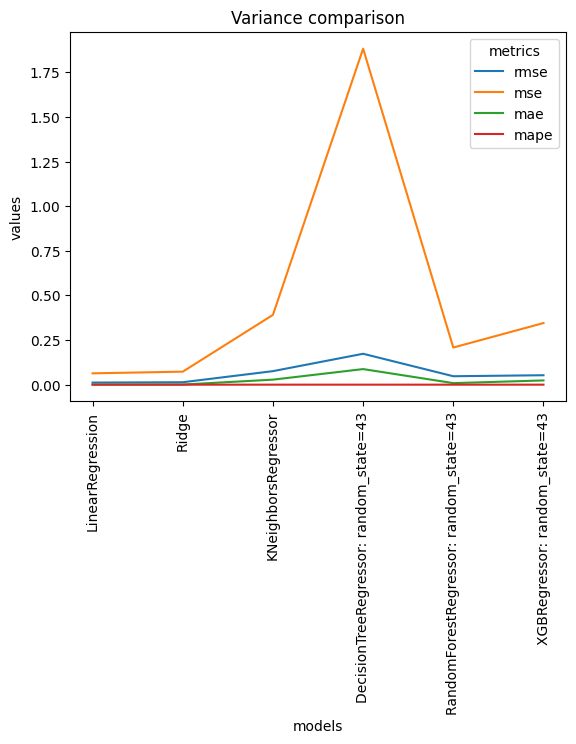

In [528]:
# Se visualiza la varianza entre los "folds"
baseline.create_dataframe(chosen_format='variance')
baseline.visualize('rmse', 'mse', 'mae', 'mape')


### Todos los barrios

#### Preparación

In [529]:
# Se hace lo que en la preparación anterior, pero con todos los barrios, y se guardan los dataframes resultantes en un dicccionario
dict_df = dict()
for col in df_acoustics.columns:
    df_uno = df_acoustics[[col]]
    df_uno = df_uno.rename(columns={col: 'x'})
    n = len(df_uno)
    for i in range(n+1):
        df_uno[f'x-{i}'] = df_uno['x'].shift(i)
    df_uno = df_uno.sort_index(ascending=False)
    df_uno = df_uno.drop(columns='x-0')
    df_uno_shortened = df_uno[df_uno.columns[:13]].dropna()
    dict_df[col] = df_uno_shortened

dict_df['Alto Extremadura'].head()


zonas,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,x-9,x-10,x-11,x-12
mes,,,,,,,,,,,,,
2023-02-01,54.4,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1
2023-01-01,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2
2022-12-01,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5
2022-11-01,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5,55.6
2022-10-01,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5,55.6,55.0


In [3]:
with open('data/processed/dict_dfs_month.pkl', 'wb') as f:
    pickle.dump(dict_df, f)


In [2]:
with open('data/processed/dict_dfs_month.pkl', 'rb') as f:
    dict_df = pickle.load(f)

dict_df['Alto Extremadura'].head()


zonas,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,x-9,x-10,x-11,x-12
mes,,,,,,,,,,,,,
2023-02-01,54.4,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1
2023-01-01,55.0,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2
2022-12-01,55.3,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5
2022-11-01,55.2,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5,55.6
2022-10-01,54.0,54.0,51.9,53.4,55.0,55.0,53.2,55.8,55.1,55.2,55.5,55.6,55.0


#### Predicción

##### Prueba (6 meses)

In [532]:
# Se prueba con predecir los 6 ultimos meses mediante varios modelos
n_iterations = 6
best_models_dict = dict()
for col in df_acoustics.columns:
    print(f'{col}:')
    df_zone = dict_df[col].loc[:'2022-08-01']
    best_model = [0, 0, 0, 0, 0, 0]
    for model, model_name in ([XGBRegressor(random_state=40), 'xgb'], 
                              [RandomForestRegressor(random_state=40), 'rf'], 
                              [SVR(), 'svr'], 
                              [DecisionTreeRegressor(random_state=40), 'dt'], 
                              [LinearRegression(), 'lr'], 
                              [Ridge(), 'ridge'],
                              [KNeighborsRegressor(), 'knn']):
        df_zone_model = df_zone.copy()
        for iteration in range(n_iterations):
            print(f'(Iteration {iteration + 1} out of {n_iterations} with {model_name})')
            X = df_zone_model.drop(columns='x')
            y = df_zone_model['x']
            last_date = list(map(str, X.index))[0].split()[0]
            X_train = X.drop(index=last_date)
            X_test = X[X.index == last_date]
            y_train = y.drop(index=last_date)
            y_test = y[y.index == last_date]

            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            new_date = datetime.strptime(last_date, '%Y-%m-%d')
            new_date = new_date + relativedelta(months=1)

            new_row = pd.DataFrame({'x': pred, 
                                    'x-1': df_zone_model.loc[last_date][0],
                                    'x-2': df_zone_model.loc[last_date][1],
                                    'x-3': df_zone_model.loc[last_date][2],
                                    'x-4': df_zone_model.loc[last_date][3],
                                    'x-5': df_zone_model.loc[last_date][4],
                                    'x-6': df_zone_model.loc[last_date][5],
                                    'x-7': df_zone_model.loc[last_date][6],
                                    'x-8': df_zone_model.loc[last_date][7],
                                    'x-9': df_zone_model.loc[last_date][8],
                                    'x-10': df_zone_model.loc[last_date][9],
                                    'x-11': df_zone_model.loc[last_date][10],
                                    'x-12': df_zone_model.loc[last_date][11],
                                    }, 
                                    index=[new_date])
            df_zone_model = pd.concat([new_row, df_zone_model.loc[:]])

        df_pred = df_zone_model.loc['2022-08-01':]['x']
        df_test = dict_df[col].loc['2022-08-01':]['x']

        r2 = r2_score(df_test, df_pred)
        mae = mean_absolute_error(df_test, df_pred)

        if r2 > best_model[0]:
            best_model[0] = r2
            best_model[1] = mae
            best_model[2] = model_name
            best_model[3] = model
            best_model[4] = df_pred.values

    if best_model[0] != 0:
        best_models_dict[col] = best_model
    
    print('\n')


Alto Extremadura:
(Iteration 1 out of 6 with xgb)
(Iteration 2 out of 6 with xgb)
(Iteration 3 out of 6 with xgb)
(Iteration 4 out of 6 with xgb)
(Iteration 5 out of 6 with xgb)
(Iteration 6 out of 6 with xgb)
(Iteration 1 out of 6 with rf)
(Iteration 2 out of 6 with rf)
(Iteration 3 out of 6 with rf)
(Iteration 4 out of 6 with rf)
(Iteration 5 out of 6 with rf)
(Iteration 6 out of 6 with rf)
(Iteration 1 out of 6 with svr)
(Iteration 2 out of 6 with svr)
(Iteration 3 out of 6 with svr)
(Iteration 4 out of 6 with svr)
(Iteration 5 out of 6 with svr)
(Iteration 6 out of 6 with svr)
(Iteration 1 out of 6 with dt)
(Iteration 2 out of 6 with dt)
(Iteration 3 out of 6 with dt)
(Iteration 4 out of 6 with dt)
(Iteration 5 out of 6 with dt)
(Iteration 6 out of 6 with dt)
(Iteration 1 out of 6 with lr)
(Iteration 2 out of 6 with lr)
(Iteration 3 out of 6 with lr)
(Iteration 4 out of 6 with lr)
(Iteration 5 out of 6 with lr)
(Iteration 6 out of 6 with lr)
(Iteration 1 out of 6 with ridge)
(Itera

In [533]:
# Se comprueban los resultados
best_models_dict


{'Alto Extremadura': [0.8702770212454276,
  0.2857910411873945,
  'svr',
  SVR(),
  array([55.11441749, 55.25557391, 55.29382883, 55.08857314, 54.27808472,
         54.63486313, 51.9       ]),
  0],
 'Arturo Soria': [0.36840709380978187,
  0.6931745054945081,
  'knn',
  KNeighborsRegressor(),
  array([55.61515077, 56.07387077, 55.1016    , 54.59489231, 54.43353846,
         53.80676923, 57.43384615]),
  0],
 'Avda de Moratalaz': [0.8495458203374282,
  0.23175288609096004,
  'xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delt

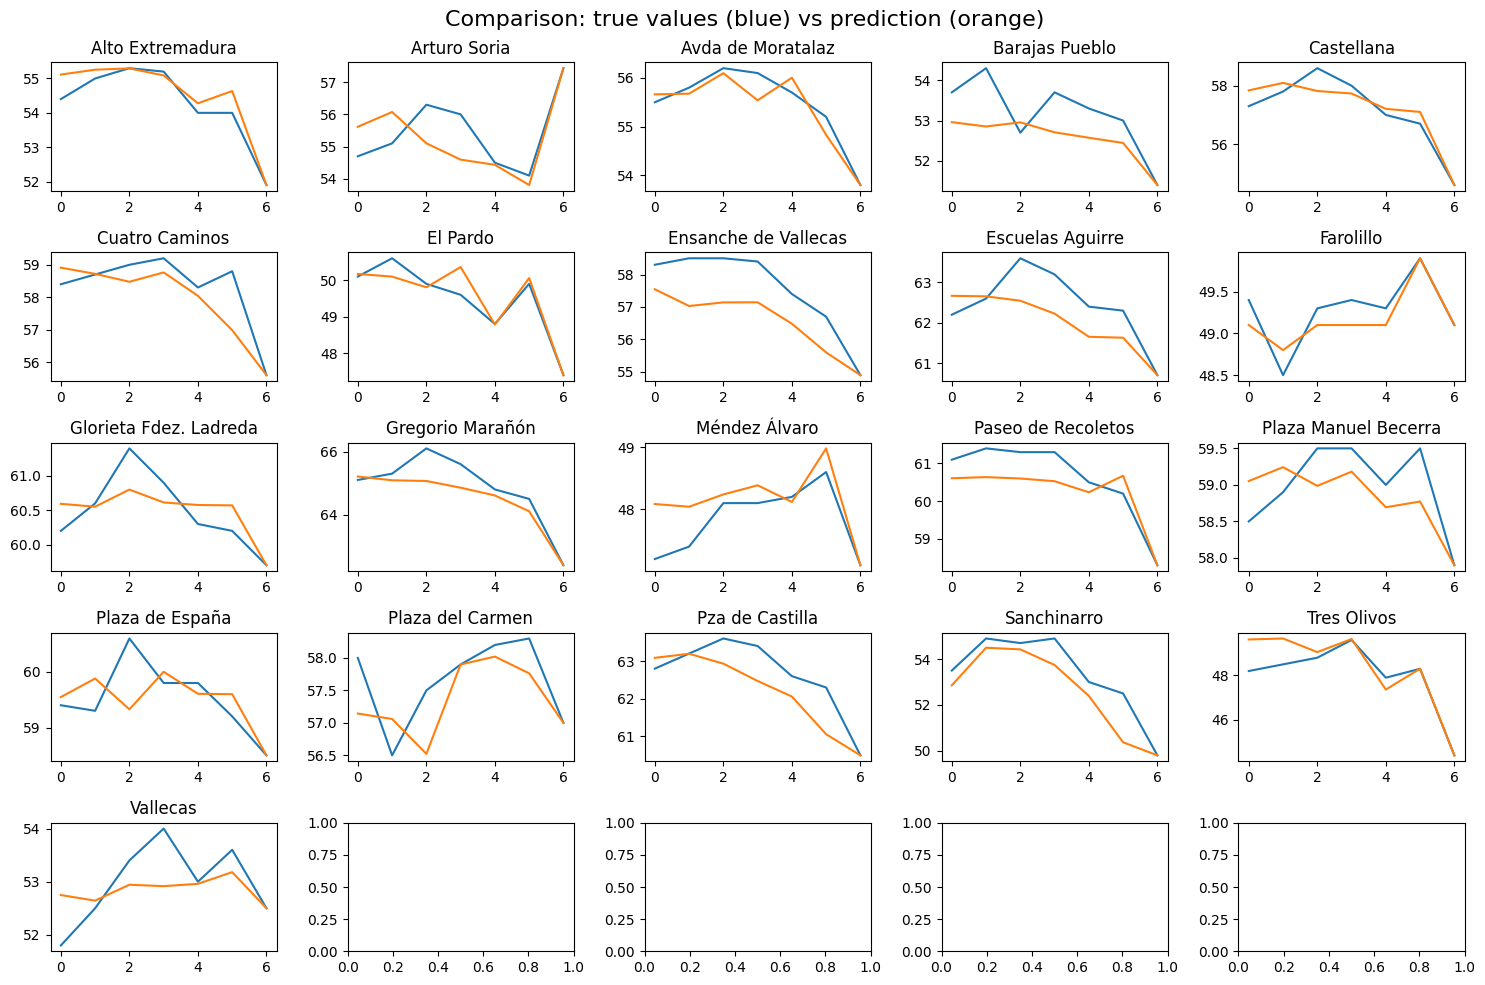

In [534]:
# Se visualizan las predicciones
num_subplots = len(best_models_dict)
num_rows = math.ceil(num_subplots / 5)
fig, axs = plt.subplots(nrows=num_rows, ncols=5, figsize=(15,10))

for i, (key, value) in enumerate(best_models_dict.items()):
    row = i // 5
    col = i % 5
    axs[row, col].plot(dict_df[key]['x'].loc['2022-08-01':].values)
    axs[row, col].plot(value[4])
    axs[row, col].set_title(key)

fig.suptitle('Comparison: true values (blue) vs prediction (orange)', fontsize=16)
plt.tight_layout()
plt.show()


In [535]:
with open('data/processed/best_models_dict.pkl', 'wb') as f:
    pickle.dump(best_models_dict, f)


In [536]:
with open('data/processed/best_models_dict.pkl', 'rb') as f:
    best_models_dict = pickle.load(f)

best_models_dict


{'Alto Extremadura': [0.8702770212454276,
  0.2857910411873945,
  'svr',
  SVR(),
  array([55.11441749, 55.25557391, 55.29382883, 55.08857314, 54.27808472,
         54.63486313, 51.9       ]),
  0],
 'Arturo Soria': [0.36840709380978187,
  0.6931745054945081,
  'knn',
  KNeighborsRegressor(),
  array([55.61515077, 56.07387077, 55.1016    , 54.59489231, 54.43353846,
         53.80676923, 57.43384615]),
  0],
 'Avda de Moratalaz': [0.8495458203374282,
  0.23175288609096004,
  'xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delt

In [563]:
# Con el mapa, no se percibe una conexión clara entre los barrios para los que la r2 es inferior a 0, salvo que la mayoría están relativamente lejos del centro
madrid_coords = [40.4168, -3.7038]

madrid_map = folium.Map(location=madrid_coords, zoom_start=12)

neighborhoods = [
    ('Barrio del Pilar', [40.4782322, -3.7115364]),
    ('Campo de las Naciones', [40.4607255, -3.6163407]),
    ('Carlos V', [40.4091095, -3.6914896]),
    ('Casa de Campo', [40.4193577, -3.7473445]),
    ('Cuatro Vientos', [40.3751984, -3.7778375]),
    ('Embajada', [40.4593153, -3.5802389]),
    ('Ramón y Cajal', [40.4514734, -3.6773491]),
    ('Santa Eugenia', [40.3790498, -3.6025322]),
    ('Urbanización Embajada II', [40.4623628, -3.5805649]),
    ('Villaverde', [40.347147, -3.7133167])
    ]

for neighborhood in neighborhoods:
    marker = folium.Marker(location=neighborhood[1], popup=neighborhood[0])
    marker.add_to(madrid_map)

madrid_map


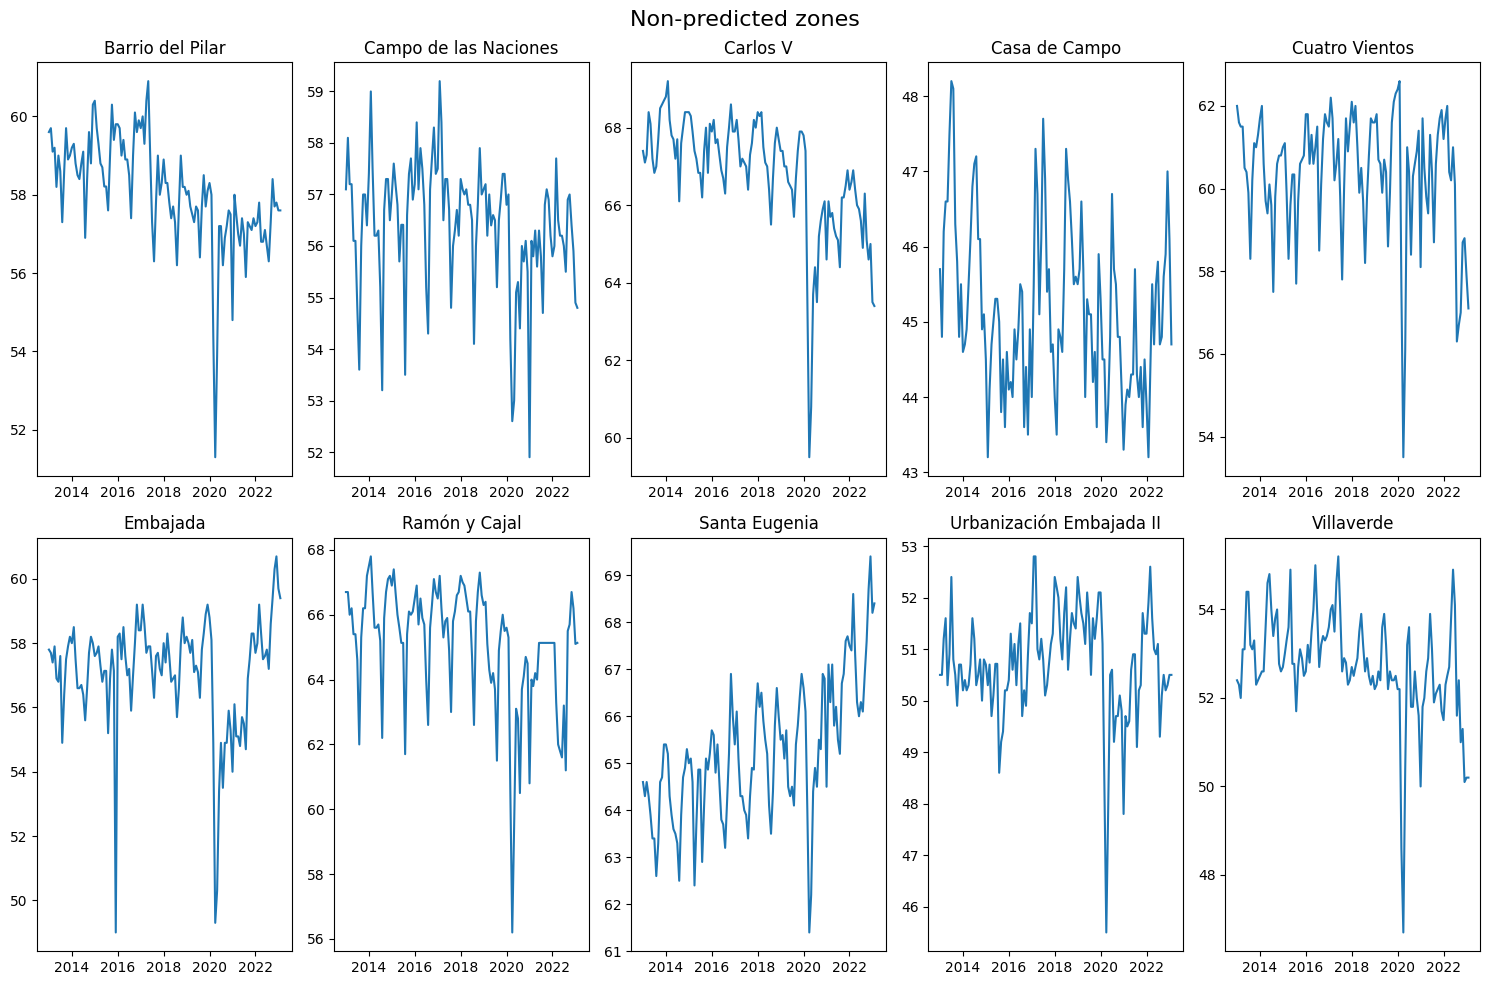

In [538]:
# Con los gráficos, se percibe que estos barrios han sufrido un cambio de ritmo reciente que hace muy difícil la predicción
non_predicted_dict = dict()
for col in df_acoustics.columns:
    if col not in best_models_dict.keys():
        non_predicted_dict[col] = df_acoustics[col]

num_subplots = len(non_predicted_dict)
num_rows = math.ceil(num_subplots / 5)
fig, axs = plt.subplots(nrows=num_rows, ncols=5, figsize=(15,10))

for i, (key, value) in enumerate(non_predicted_dict.items()):
    row = i // 5
    col = i % 5
    axs[row, col].plot(dict_df[key]['x'].loc[:])
    axs[row, col].set_title(key)

fig.suptitle('Non-predicted zones', fontsize=16)
plt.tight_layout()
plt.show()


##### Prueba (3 meses)

In [539]:
# Por tanto, para esos barrios solo, se prueba con predecir únicamente 3 meses
n_iterations = 3
best_models_dict_small = dict()
for col in df_acoustics.columns:
    if col not in best_models_dict.keys():
        print(f'{col}:')
        df_zone = dict_df[col].loc[:'2022-11-01']
        best_model = [0, 0, 0, 0, 0, 0]
        for model, model_name in ([XGBRegressor(random_state=40), 'xgb'], 
                                  [RandomForestRegressor(random_state=40), 'rf'], 
                                  [SVR(), 'svr'], 
                                  [DecisionTreeRegressor(random_state=40), 'dt'], 
                                  [LinearRegression(), 'lr'], 
                                  [Ridge(), 'ridge'],
                                  [KNeighborsRegressor(), 'knn']):
            df_zone_model = df_zone.copy()
            for iteration in range(n_iterations):
                print(f'(Iteration {iteration + 1} out of {n_iterations} with {model_name})')
                X = df_zone_model.drop(columns='x')
                y = df_zone_model['x']
                last_date = list(map(str, X.index))[0].split()[0]
                X_train = X.drop(index=last_date)
                X_test = X[X.index == last_date]
                y_train = y.drop(index=last_date)
                y_test = y[y.index == last_date]

                model.fit(X_train, y_train)
                pred = model.predict(X_test)

                new_date = datetime.strptime(last_date, '%Y-%m-%d')
                new_date = new_date + relativedelta(months=1)

                new_row = pd.DataFrame({'x': pred, 
                                        'x-1': df_zone_model.loc[last_date][0],
                                        'x-2': df_zone_model.loc[last_date][1],
                                        'x-3': df_zone_model.loc[last_date][2],
                                        'x-4': df_zone_model.loc[last_date][3],
                                        'x-5': df_zone_model.loc[last_date][4],
                                        'x-6': df_zone_model.loc[last_date][5],
                                        'x-7': df_zone_model.loc[last_date][6],
                                        'x-8': df_zone_model.loc[last_date][7],
                                        'x-9': df_zone_model.loc[last_date][8],
                                        'x-10': df_zone_model.loc[last_date][9],
                                        'x-11': df_zone_model.loc[last_date][10],
                                        'x-12': df_zone_model.loc[last_date][11],
                                        }, 
                                        index=[new_date])
                df_zone_model = pd.concat([new_row, df_zone_model.loc[:]])

            df_pred = df_zone_model.loc['2022-11-01':]['x']
            df_test = dict_df[col].loc['2022-11-01':]['x']

            r2 = r2_score(df_test, df_pred)
            mae = mean_absolute_error(df_test, df_pred)

            if r2 > best_model[0]:
                best_model[0] = r2
                best_model[1] = mae
                best_model[2] = model_name
                best_model[3] = model
                best_model[4] = df_pred.values

        if best_model[0] != 0:
            best_models_dict_small[col] = best_model

        print('\n')


Barrio del Pilar:
(Iteration 1 out of 3 with xgb)
(Iteration 2 out of 3 with xgb)
(Iteration 3 out of 3 with xgb)
(Iteration 1 out of 3 with rf)
(Iteration 2 out of 3 with rf)
(Iteration 3 out of 3 with rf)
(Iteration 1 out of 3 with svr)
(Iteration 2 out of 3 with svr)
(Iteration 3 out of 3 with svr)
(Iteration 1 out of 3 with dt)
(Iteration 2 out of 3 with dt)
(Iteration 3 out of 3 with dt)
(Iteration 1 out of 3 with lr)
(Iteration 2 out of 3 with lr)
(Iteration 3 out of 3 with lr)
(Iteration 1 out of 3 with ridge)
(Iteration 2 out of 3 with ridge)
(Iteration 3 out of 3 with ridge)
(Iteration 1 out of 3 with knn)
(Iteration 2 out of 3 with knn)
(Iteration 3 out of 3 with knn)


Campo de las Naciones:
(Iteration 1 out of 3 with xgb)
(Iteration 2 out of 3 with xgb)
(Iteration 3 out of 3 with xgb)
(Iteration 1 out of 3 with rf)
(Iteration 2 out of 3 with rf)
(Iteration 3 out of 3 with rf)
(Iteration 1 out of 3 with svr)
(Iteration 2 out of 3 with svr)
(Iteration 3 out of 3 with svr)
(It

In [540]:
# Se comprueban los resultados
best_models_dict_small


{'Casa de Campo': [0.5944186046511636,
  0.42499999999999893,
  'dt',
  DecisionTreeRegressor(random_state=40),
  array([45.5, 45.5, 46.7, 45.9]),
  0],
 'Ramón y Cajal': [0.3950422140454166,
  0.44672142647756274,
  'ridge',
  Ridge(),
  array([64.7780989 , 65.83262298, 65.4996056 , 66.7       ]),
  0],
 'Urbanización Embajada II': [0.08047268426974186,
  0.10739693181819376,
  'rf',
  RandomForestRegressor(random_state=40),
  array([50.35841227, 50.33943182, 50.42743182, 50.2       ]),
  0]}

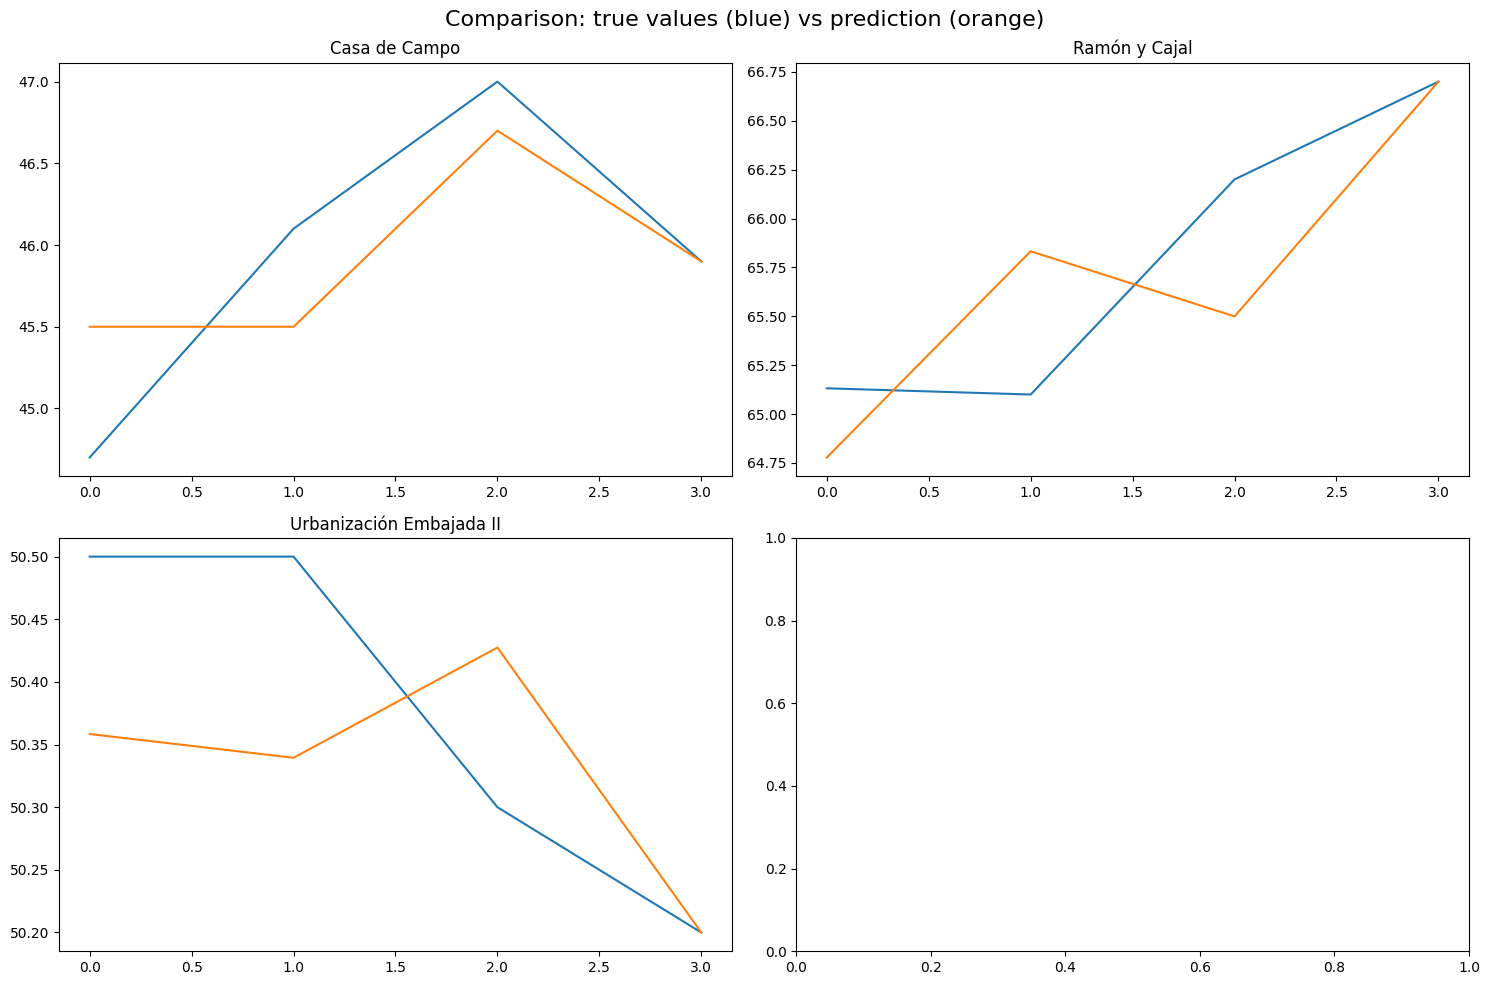

In [541]:
# Se visualizan las predicciones
num_subplots = len(best_models_dict_small)
num_rows = math.ceil(num_subplots / 2)
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15,10))

for i, (key, value) in enumerate(best_models_dict_small.items()):
    row = i // 2
    col = i % 2
    axs[row, col].plot(dict_df[key]['x'].loc['2022-11-01':].values)
    axs[row, col].plot(value[4])
    axs[row, col].set_title(key)

fig.suptitle('Comparison: true values (blue) vs prediction (orange)', fontsize=16)
plt.tight_layout()
plt.show()


In [542]:
with open('data/processed/best_models_dict_small.pkl', 'wb') as f:
    pickle.dump(best_models_dict_small, f)


In [543]:
with open('data/processed/best_models_dict_small.pkl', 'rb') as f:
    best_models_dict_small = pickle.load(f)

best_models_dict_small


{'Casa de Campo': [0.5944186046511636,
  0.42499999999999893,
  'dt',
  DecisionTreeRegressor(random_state=40),
  array([45.5, 45.5, 46.7, 45.9]),
  0],
 'Ramón y Cajal': [0.3950422140454166,
  0.44672142647756274,
  'ridge',
  Ridge(),
  array([64.7780989 , 65.83262298, 65.4996056 , 66.7       ]),
  0],
 'Urbanización Embajada II': [0.08047268426974186,
  0.10739693181819376,
  'rf',
  RandomForestRegressor(random_state=40),
  array([50.35841227, 50.33943182, 50.42743182, 50.2       ]),
  0]}

##### Final

###### 6 meses

In [544]:
# Se empieza con predecir los barrios que han funcionado bien con 6 meses
n_iterations = 6
results_dict = dict()
for col in df_acoustics.columns:
    if col in best_models_dict.keys():
        print(f'{col}:')
        df_zone = dict_df[col].loc[:]
        best_model = [0, 0, 0, 0, 0, 0]
        model_name = best_models_dict[col][2]
        if model_name == 'xgb':
            model = XGBRegressor(random_state=40)
        elif model_name == 'rf':
            model = RandomForestRegressor(random_state=40)
        elif model_name == 'svr':
            model = SVR()
        elif model_name == 'dt':
            model = DecisionTreeRegressor(random_state=40)
        elif model_name == 'lr':
            model = LinearRegression()
        elif model_name == 'ridge':
            model = Ridge()
        else:
            model = KNeighborsRegressor()
        df_zone_model = df_zone.copy()
        for iteration in range(n_iterations):
            print(f'(Iteration {iteration + 1} out of {n_iterations} with {model_name})')
            X = df_zone_model.drop(columns='x')
            y = df_zone_model['x']
            last_date = list(map(str, X.index))[0].split()[0]
            X_train = X.drop(index=last_date)
            X_test = X[X.index == last_date]
            y_train = y.drop(index=last_date)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            new_date = datetime.strptime(last_date, '%Y-%m-%d')
            new_date = new_date + relativedelta(months=1)

            new_row = pd.DataFrame({'x': pred, 
                                    'x-1': df_zone_model.loc[last_date][0],
                                    'x-2': df_zone_model.loc[last_date][1],
                                    'x-3': df_zone_model.loc[last_date][2],
                                    'x-4': df_zone_model.loc[last_date][3],
                                    'x-5': df_zone_model.loc[last_date][4],
                                    'x-6': df_zone_model.loc[last_date][5],
                                    'x-7': df_zone_model.loc[last_date][6],
                                    'x-8': df_zone_model.loc[last_date][7],
                                    'x-9': df_zone_model.loc[last_date][8],
                                    'x-10': df_zone_model.loc[last_date][9],
                                    'x-11': df_zone_model.loc[last_date][10],
                                    'x-12': df_zone_model.loc[last_date][11],
                                    }, 
                                    index=[new_date])
            df_zone_model = pd.concat([new_row, df_zone_model.loc[:]])

        df_pred = df_zone_model.loc[:]['x']
        results_dict[col] = df_pred


Alto Extremadura:
(Iteration 1 out of 6 with svr)
(Iteration 2 out of 6 with svr)
(Iteration 3 out of 6 with svr)
(Iteration 4 out of 6 with svr)
(Iteration 5 out of 6 with svr)
(Iteration 6 out of 6 with svr)
Arturo Soria:
(Iteration 1 out of 6 with knn)
(Iteration 2 out of 6 with knn)
(Iteration 3 out of 6 with knn)
(Iteration 4 out of 6 with knn)
(Iteration 5 out of 6 with knn)
(Iteration 6 out of 6 with knn)
Avda de Moratalaz:
(Iteration 1 out of 6 with xgb)
(Iteration 2 out of 6 with xgb)
(Iteration 3 out of 6 with xgb)
(Iteration 4 out of 6 with xgb)
(Iteration 5 out of 6 with xgb)
(Iteration 6 out of 6 with xgb)
Barajas Pueblo:
(Iteration 1 out of 6 with rf)
(Iteration 2 out of 6 with rf)
(Iteration 3 out of 6 with rf)
(Iteration 4 out of 6 with rf)
(Iteration 5 out of 6 with rf)
(Iteration 6 out of 6 with rf)
Castellana:
(Iteration 1 out of 6 with svr)
(Iteration 2 out of 6 with svr)
(Iteration 3 out of 6 with svr)
(Iteration 4 out of 6 with svr)
(Iteration 5 out of 6 with svr)

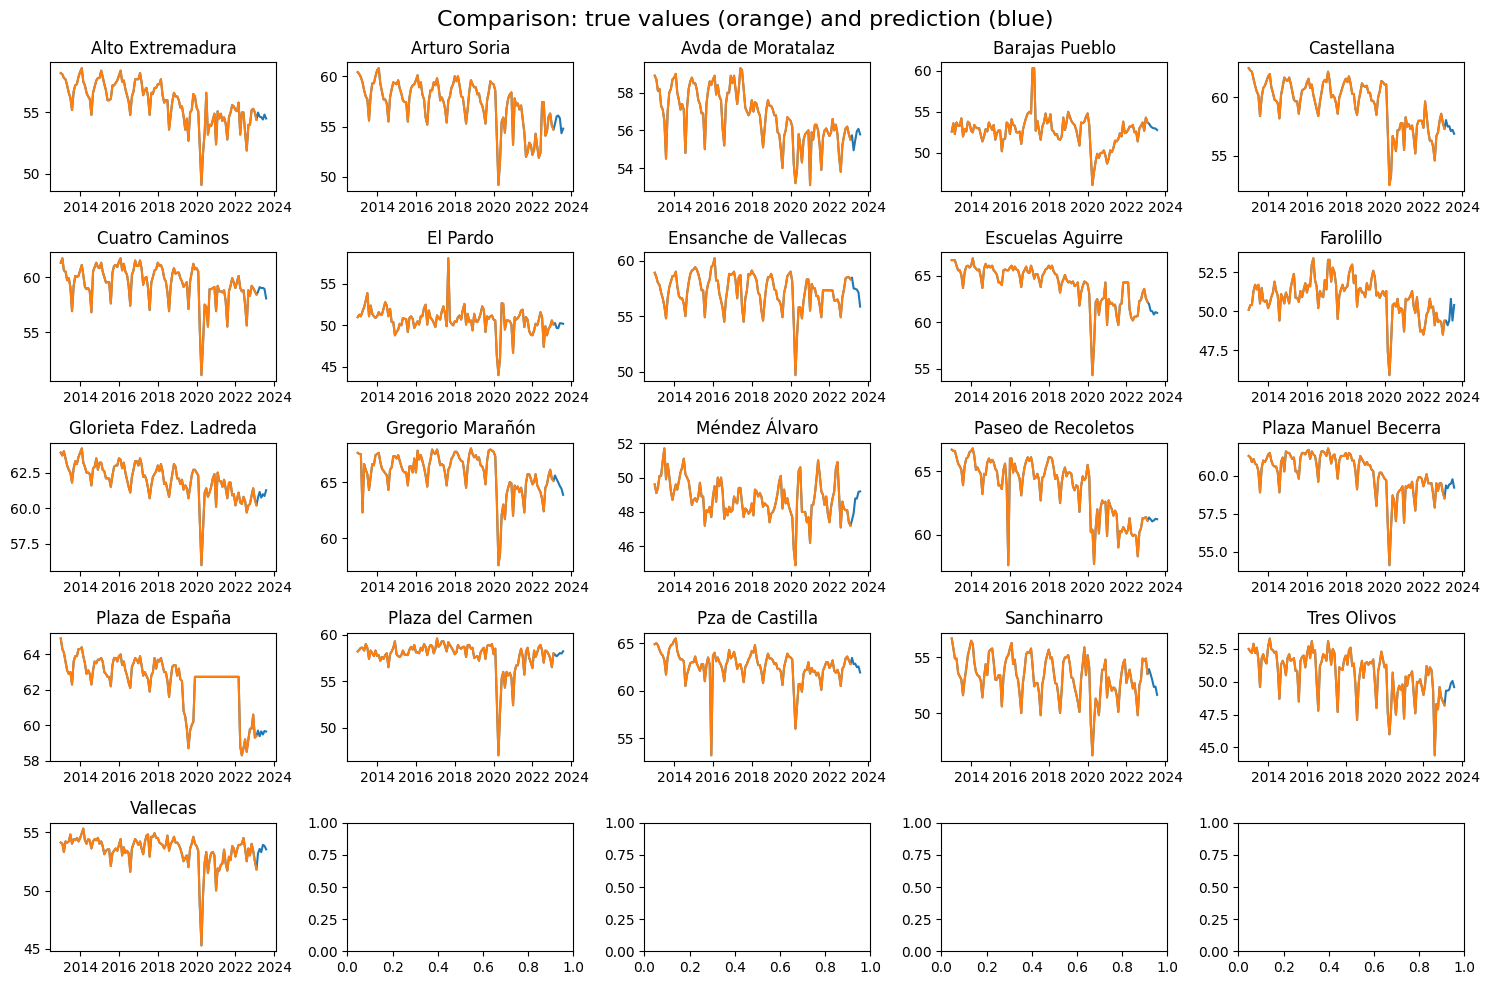

In [545]:
# Se visualizan las predicciones
num_subplots = len(results_dict)
num_rows = math.ceil(num_subplots / 5)
fig, axs = plt.subplots(nrows=num_rows, ncols=5, figsize=(15,10))

for i, (key, value) in enumerate(results_dict.items()):
    row = i // 5
    col = i % 5
    axs[row, col].plot(value)
    axs[row, col].plot(dict_df[key]['x'].loc[:])
    axs[row, col].set_title(key)

fig.suptitle('Comparison: true values (orange) and prediction (blue)', fontsize=16)
plt.tight_layout()
plt.show()


In [546]:
with open('data/processed/final_predictions_6_months.pkl', 'wb') as f:
    pickle.dump(results_dict, f)


In [3]:
with open('data/processed/final_predictions_6_months.pkl', 'rb') as f:
    results_dict = pickle.load(f)

results_dict


{'Alto Extremadura': 2023-08-01    54.509468
 2023-07-01    54.830151
 2023-06-01    54.427288
 2023-05-01    54.624203
 2023-04-01    54.651347
                 ...    
 2013-05-01    57.200000
 2013-04-01    57.700000
 2013-03-01    57.800000
 2013-02-01    58.100000
 2013-01-01    58.200000
 Name: x, Length: 128, dtype: float64,
 'Arturo Soria': 2023-08-01    54.8008
 2023-07-01    54.3392
 2023-06-01    55.8240
 2023-05-01    56.0960
 2023-04-01    56.0200
                ...   
 2013-05-01    58.6000
 2013-04-01    59.4000
 2013-03-01    59.9000
 2013-02-01    60.2000
 2013-01-01    60.4000
 Name: x, Length: 128, dtype: float64,
 'Avda de Moratalaz': 2023-08-01    55.786060
 2023-07-01    56.081333
 2023-06-01    55.958099
 2023-05-01    55.475693
 2023-04-01    54.943504
                 ...    
 2013-05-01    57.300000
 2013-04-01    58.200000
 2013-03-01    58.100000
 2013-02-01    58.700000
 2013-01-01    58.900000
 Name: x, Length: 128, dtype: float64,
 'Barajas Pueblo': 2023

###### 3 meses

In [548]:
# Se predice, ahora, con los barrios que han funcionado bien con 3 meses
n_iterations = 3
results_dict_small = dict()
for col in df_acoustics.columns:
    if col in best_models_dict_small.keys():
        print(f'{col}:')
        df_zone = dict_df[col].loc[:]
        best_model = [0, 0, 0, 0, 0, 0]
        model_name = best_models_dict_small[col][2]
        if model_name == 'xgb':
            model = XGBRegressor(random_state=40)
        elif model_name == 'rf':
            model = RandomForestRegressor(random_state=40)
        elif model_name == 'svr':
            model = SVR()
        elif model_name == 'dt':
            model = DecisionTreeRegressor(random_state=40)
        elif model_name == 'lr':
            model = LinearRegression()
        elif model_name == 'ridge':
            model = Ridge()
        else:
            model = KNeighborsRegressor()
        df_zone_model = df_zone.copy()
        for iteration in range(n_iterations):
            print(f'(Iteration {iteration + 1} out of {n_iterations} with {model_name})')
            X = df_zone_model.drop(columns='x')
            y = df_zone_model['x']
            last_date = list(map(str, X.index))[0].split()[0]
            X_train = X.drop(index=last_date)
            X_test = X[X.index == last_date]
            y_train = y.drop(index=last_date)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            new_date = datetime.strptime(last_date, '%Y-%m-%d')
            new_date = new_date + relativedelta(months=1)

            new_row = pd.DataFrame({'x': pred, 
                                    'x-1': df_zone_model.loc[last_date][0],
                                    'x-2': df_zone_model.loc[last_date][1],
                                    'x-3': df_zone_model.loc[last_date][2],
                                    'x-4': df_zone_model.loc[last_date][3],
                                    'x-5': df_zone_model.loc[last_date][4],
                                    'x-6': df_zone_model.loc[last_date][5],
                                    'x-7': df_zone_model.loc[last_date][6],
                                    'x-8': df_zone_model.loc[last_date][7],
                                    'x-9': df_zone_model.loc[last_date][8],
                                    'x-10': df_zone_model.loc[last_date][9],
                                    'x-11': df_zone_model.loc[last_date][10],
                                    'x-12': df_zone_model.loc[last_date][11],
                                    }, 
                                    index=[new_date])
            df_zone_model = pd.concat([new_row, df_zone_model.loc[:]])

        df_pred = df_zone_model.loc[:]['x']
        results_dict_small[col] = df_pred


Casa de Campo:
(Iteration 1 out of 3 with dt)
(Iteration 2 out of 3 with dt)
(Iteration 3 out of 3 with dt)
Ramón y Cajal:
(Iteration 1 out of 3 with ridge)
(Iteration 2 out of 3 with ridge)
(Iteration 3 out of 3 with ridge)
Urbanización Embajada II:
(Iteration 1 out of 3 with rf)
(Iteration 2 out of 3 with rf)
(Iteration 3 out of 3 with rf)


In [549]:
# Se comprueban los resultados
results_dict_small


{'Casa de Campo': 2023-05-01    44.2
 2023-04-01    45.6
 2023-03-01    45.5
 2023-02-01    44.7
 2023-01-01    46.1
               ... 
 2013-05-01    46.6
 2013-04-01    46.6
 2013-03-01    46.2
 2013-02-01    44.8
 2013-01-01    45.7
 Name: x, Length: 125, dtype: float64,
 'Ramón y Cajal': 2023-05-01    63.959358
 2023-04-01    63.554454
 2023-03-01    65.293346
 2023-02-01    65.131967
 2023-01-01    65.100000
                 ...    
 2013-05-01    65.400000
 2013-04-01    66.200000
 2013-03-01    66.000000
 2013-02-01    66.700000
 2013-01-01    66.700000
 Name: x, Length: 125, dtype: float64,
 'Urbanización Embajada II': 2023-05-01    50.791596
 2023-04-01    50.528720
 2023-03-01    50.848144
 2023-02-01    50.500000
 2023-01-01    50.500000
                 ...    
 2013-05-01    50.300000
 2013-04-01    51.600000
 2013-03-01    51.200000
 2013-02-01    50.500000
 2013-01-01    50.500000
 Name: x, Length: 125, dtype: float64}

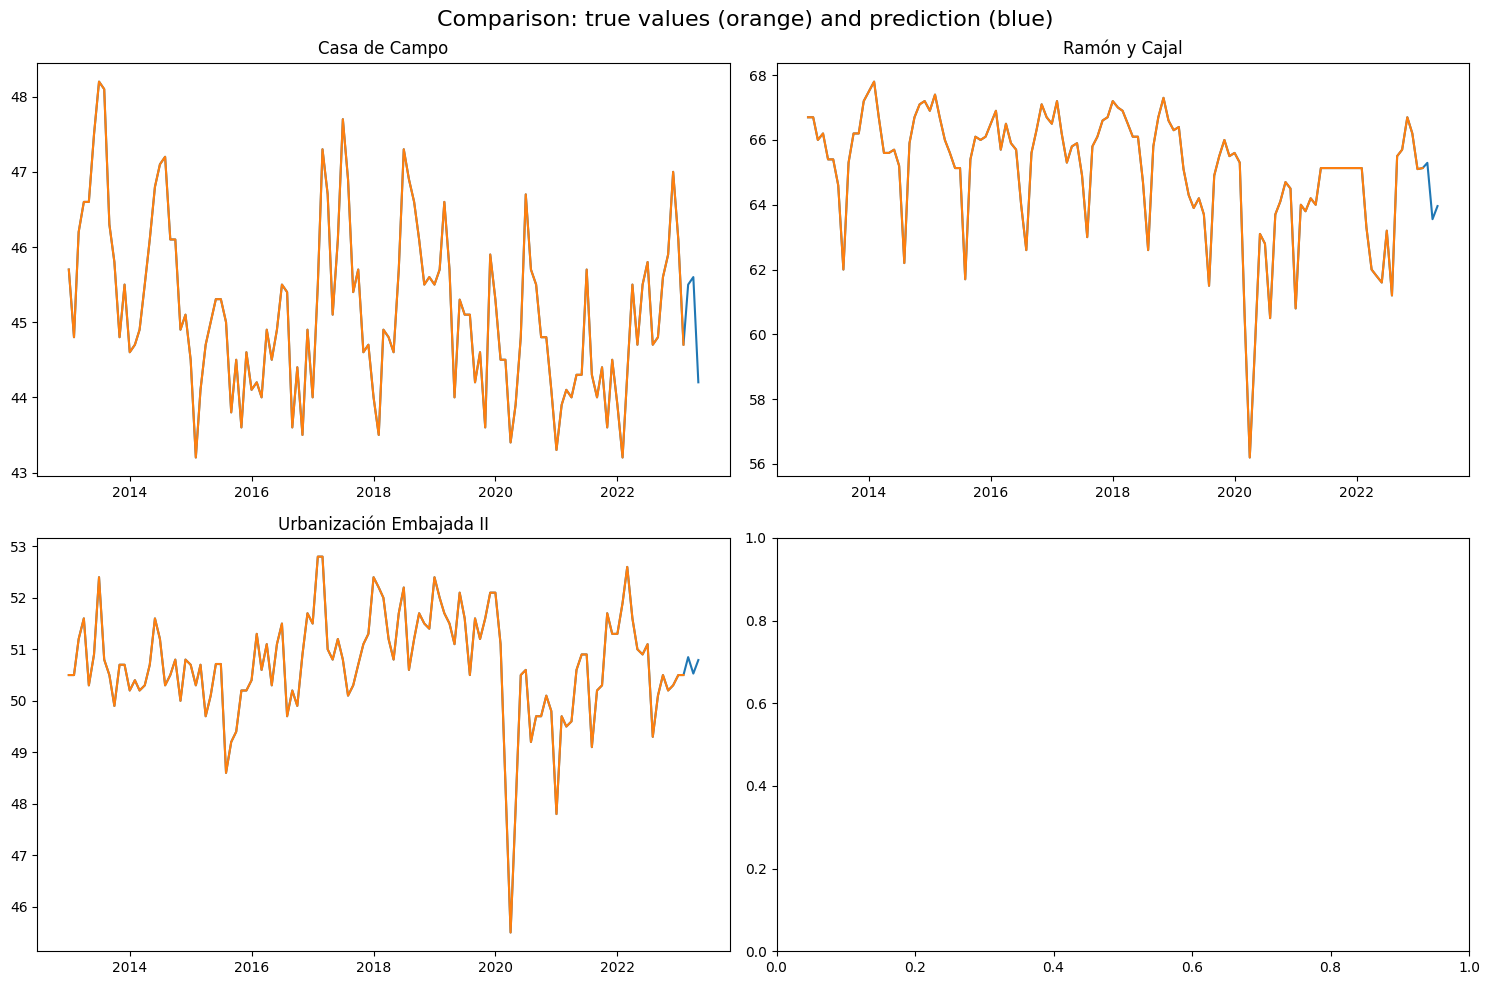

In [550]:
# Se visualizan las predicciones
num_subplots = len(results_dict_small)
num_rows = math.ceil(num_subplots / 2)
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15,10))

for i, (key, value) in enumerate(results_dict_small.items()):
    row = i // 2
    col = i % 2
    axs[row, col].plot(value)
    axs[row, col].plot(dict_df[key]['x'].loc[:])
    axs[row, col].set_title(key)

fig.suptitle('Comparison: true values (orange) and prediction (blue)', fontsize=16)
plt.tight_layout()
plt.show()


In [551]:
with open('data/processed/final_predictions_3_months.pkl', 'wb') as f:
    pickle.dump(results_dict_small, f)


In [4]:
with open('data/processed/final_predictions_3_months.pkl', 'rb') as f:
    results_dict_small = pickle.load(f)

results_dict_small


{'Casa de Campo': 2023-05-01    44.2
 2023-04-01    45.6
 2023-03-01    45.5
 2023-02-01    44.7
 2023-01-01    46.1
               ... 
 2013-05-01    46.6
 2013-04-01    46.6
 2013-03-01    46.2
 2013-02-01    44.8
 2013-01-01    45.7
 Name: x, Length: 125, dtype: float64,
 'Ramón y Cajal': 2023-05-01    63.959358
 2023-04-01    63.554454
 2023-03-01    65.293346
 2023-02-01    65.131967
 2023-01-01    65.100000
                 ...    
 2013-05-01    65.400000
 2013-04-01    66.200000
 2013-03-01    66.000000
 2013-02-01    66.700000
 2013-01-01    66.700000
 Name: x, Length: 125, dtype: float64,
 'Urbanización Embajada II': 2023-05-01    50.791596
 2023-04-01    50.528720
 2023-03-01    50.848144
 2023-02-01    50.500000
 2023-01-01    50.500000
                 ...    
 2013-05-01    50.300000
 2013-04-01    51.600000
 2013-03-01    51.200000
 2013-02-01    50.500000
 2013-01-01    50.500000
 Name: x, Length: 125, dtype: float64}

# Conclusiones OMS

## 6 meses

In [5]:
# Se utiliza el estándar de la OMS para predecir la gravedad de la contaminación acústica a 6 meses por barrio
print('Para agosto de 2023, según los límites marcados por la OMS:')
for key, value in results_dict.items():
    last_date = list(map(str, value.index))[0].split()[0]
    last_prediction = value[value.index == last_date].values[0]
    if last_prediction < 55.0:
        continue
    elif last_prediction < 60.0:
        print(f'- La contaminación de la zona de {key} causará molestias en las personas ({round(last_prediction, 2)} dBA la mayoría del tiempo).')
    elif last_prediction < 65.0:
        print(f'- La contaminación de la zona de {key} causará molestias serias en las personas ({round(last_prediction, 2)} dBA la mayoría del tiempo).')
    else:
        print(f'- La contaminación de la zona de {key} producirá transtornos de comportamiento ({round(last_prediction, 2)} dBA la mayoría del tiempo).')


Para agosto de 2023, según los límites marcados por la OMS:
- La contaminación de la zona de Avda de Moratalaz causará molestias en las personas (55.79 dBA la mayoría del tiempo).
- La contaminación de la zona de Castellana causará molestias en las personas (56.89 dBA la mayoría del tiempo).
- La contaminación de la zona de Cuatro Caminos causará molestias en las personas (58.06 dBA la mayoría del tiempo).
- La contaminación de la zona de Ensanche de Vallecas causará molestias en las personas (55.86 dBA la mayoría del tiempo).
- La contaminación de la zona de Escuelas Aguirre causará molestias serias en las personas (61.01 dBA la mayoría del tiempo).
- La contaminación de la zona de Glorieta Fdez. Ladreda causará molestias serias en las personas (61.26 dBA la mayoría del tiempo).
- La contaminación de la zona de Gregorio Marañón causará molestias serias en las personas (63.87 dBA la mayoría del tiempo).
- La contaminación de la zona de Paseo de Recoletos causará molestias serias en las

In [6]:
# Como la contaminación acústica se reduce en agosto, se repite el proceso con la media de los 6 meses. Arturo Soria se suma al grupo
print('Desde marzo de 2023 a agosto de 2023, según los límites marcados por la OMS:')
for key, value in results_dict.items():
    last_date = list(map(str, value.index))[0].split()[0]
    mean_predictions = value[:6].mean()
    if mean_predictions < 55.0:
        continue
    elif mean_predictions < 60.0:
        print(f'- La contaminación de la zona de {key} causará molestias en las personas ({round(mean_predictions, 2)} dBA la mayoría del tiempo).')
    elif mean_predictions < 65.0:
        print(f'- La contaminación de la zona de {key} causará molestias serias en las personas ({round(mean_predictions, 2)} dBA la mayoría del tiempo).')
    else:
        print(f'- La contaminación de la zona de {key} producirá transtornos de comportamiento ({round(mean_predictions, 2)} dBA la mayoría del tiempo).')


Desde marzo de 2023 a agosto de 2023, según los límites marcados por la OMS:
- La contaminación de la zona de Arturo Soria causará molestias en las personas (55.39 dBA la mayoría del tiempo).
- La contaminación de la zona de Avda de Moratalaz causará molestias en las personas (55.66 dBA la mayoría del tiempo).
- La contaminación de la zona de Castellana causará molestias en las personas (57.39 dBA la mayoría del tiempo).
- La contaminación de la zona de Cuatro Caminos causará molestias en las personas (58.79 dBA la mayoría del tiempo).
- La contaminación de la zona de Ensanche de Vallecas causará molestias en las personas (57.29 dBA la mayoría del tiempo).
- La contaminación de la zona de Escuelas Aguirre causará molestias serias en las personas (61.22 dBA la mayoría del tiempo).
- La contaminación de la zona de Glorieta Fdez. Ladreda causará molestias serias en las personas (60.96 dBA la mayoría del tiempo).
- La contaminación de la zona de Gregorio Marañón causará molestias serias en

## 3 meses

In [7]:
# Se utiliza el estándar de la OMS para predecir la gravedad de la contaminación acústica a 3 meses por barrio
print('Para mayo de 2023, según los límites marcados por la OMS:')
for key, value in results_dict_small.items():
    last_date = list(map(str, value.index))[0].split()[0]
    last_prediction = value[value.index == last_date].values[0]
    if last_prediction < 55.0:
        continue
    elif last_prediction < 60.0:
        print(f'- La contaminación de la zona de {key} causará molestias en las personas ({round(last_prediction, 2)} dBA la mayoría del tiempo).')
    elif last_prediction < 65.0:
        print(f'- La contaminación de la zona de {key} causará molestias serias en las personas ({round(last_prediction, 2)} dBA la mayoría del tiempo).')
    else:
        print(f'- La contaminación de la zona de {key} producirá transtornos de comportamiento ({round(last_prediction, 2)} dBA la mayoría del tiempo).')


Para mayo de 2023, según los límites marcados por la OMS:
- La contaminación de la zona de Ramón y Cajal causará molestias serias en las personas (63.96 dBA la mayoría del tiempo).


In [8]:
# Se repite con la media. El resultado es el mismo
print('Desde marzo de 2023 a agosto de 2023, según los límites marcados por la OMS:')
for key, value in results_dict_small.items():
    last_date = list(map(str, value.index))[0].split()[0]
    mean_predictions = value[:3].mean()
    if mean_predictions < 55.0:
        continue
    elif mean_predictions < 60.0:
        print(f'- La contaminación de la zona de {key} causará molestias en las personas ({round(mean_predictions, 2)} dBA la mayoría del tiempo).')
    elif mean_predictions < 65.0:
        print(f'- La contaminación de la zona de {key} causará molestias serias en las personas ({round(mean_predictions, 2)} dBA la mayoría del tiempo).')
    else:
        print(f'- La contaminación de la zona de {key} producirá transtornos de comportamiento ({round(mean_predictions, 2)} dBA la mayoría del tiempo).')


Desde marzo de 2023 a agosto de 2023, según los límites marcados por la OMS:
- La contaminación de la zona de Ramón y Cajal causará molestias serias en las personas (64.27 dBA la mayoría del tiempo).


# Recomendaciones patinetes

In [8]:
# Estas son las ubicaciónes de las estaciones de medida cerca de donde valdria la pena poner patinetes para reducir la contaminación
madrid_coords = [40.4168, -3.7038]

madrid_map = folium.Map(location=madrid_coords, zoom_start=12)

neighborhoods = [
    ('Arturo Soria', [40.4400457, -3.6392422]),
    ('Avda de Moratalaz', [40.4079517, -3.6453104]),
    ('Castellana', [40.4398904, -3.6903729]),
    ('Cuatro Caminos', [40.4455439, -3.7071303]),
    ('Ensanche de Vallecas', [40.3730118, -3.6121394]),
    ('Escuelas Aguirre', [40.4215533, -3.6823158]),
    ('Glorieta Fdez. Ladreda', [40.3850336, -3.7187679]),
    ('Gregorio Marañón', [40.4375685, -3.6907851]),
    ('Paseo de Recoletos', [40.42262, -3.6919264]),
    ('Plaza Manuel Becerra', [40.4288108, -3.6685709]),
    ('Plaza de España', [40.4238823, -3.7122567]),
    ('Plaza del Carmen', [40.4192091, -3.7031662]),
    ('Pza de Castilla', [40.4655841, -3.6887449]),
    ('Ramón y Cajal', [40.4514734, -3.6773491])
    ]

for neighborhood in neighborhoods:
    marker = folium.Marker(location=neighborhood[1], popup=neighborhood[0])
    marker.add_to(madrid_map)

madrid_map


In [15]:
# Se usa el radio de la Tierra y la fórmula de Harversine para obtener la distancia que separa las coordenadas de las dos estaciones de medida más cercanas
distance = []
R = 6371

name1, (lat1, lon1) = ('Gregorio Marañón', [40.4375685, -3.6907851])
name2, (lat2, lon2) = ('Castellana', [40.4398904, -3.6903729])
dLat = math.radians(lat2 - lat1)
dLon = math.radians(lon2 - lon1)
a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)
c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
d = R * c
print(d)


0.26052957686609113


In [16]:
# Dando por hecho que no tendría sentido que una estación de medida estuivese dentro del rango de acción de otra, se obtiene un nuevo mapa con el radio de acción aproximado de cada una
madrid_map = folium.Map(location=madrid_coords, zoom_start=12)

for neighborhood in neighborhoods:
    folium.Circle(location=neighborhood[1], radius=0.26052957686609113 * 1000,
                  fill_color='blue', fill_opacity=0.3).add_to(madrid_map)

madrid_map
